In [1]:
from model import ASAG
import os
import numpy as np
import pandas as pd
import re
import seaborn as sns
import features.functional as F

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
asag = ASAG()

In [7]:
asag.load_train_model()

/Users/starlight/anaconda3/envs/asag/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Models - Word Model Loaded


Using cache found in /Users/starlight/.cache/torch/hub/pytorch_fairseq_master


Models - RoBERTa Loaded
Models - Functional Words Loaded
Models - Loading Complete
Loading sample data
Total Responses: 3689. Total Questions: 76
Sample Data Loaded
Tuned Threshold: 0.42
Accuracy:  0.8197831978319783
F1:  0.6956521739130435
Precision:  0.7004608294930875
Recall:  0.6909090909090909
Model Trained and Stored


In [8]:
asag.classifier_model.feature_importances_

array([0.05590953, 0.05935539, 0.07327683, 0.09064891, 0.03012229,
       0.00977202, 0.0657856 , 0.05438525, 0.05587397, 0.08230032,
       0.05852265, 0.11773294, 0.0994136 , 0.04109768, 0.04887142,
       0.0569316 ])

In [9]:
# Get GIM Answers, Questions, Student Answers
df_response = pd.read_excel('Data/10X Capital Worksheet (Marked).xlsx').iloc[:,3:].iloc[:,np.arange(0,20,2)]
df_mark = pd.read_excel('Data/10X Capital Worksheet (Marked).xlsx').iloc[:,3:].iloc[:,np.arange(1,19,2)] # Only take for the first 9 questions
df_answers = pd.read_excel('Data/Answers.xlsx')
y_truth = pd.melt(df_mark).value.values
gim_student_answers = [df_response.transpose().iloc[i,:].to_list() for i in range(10)]
gim_reference_answers = df_answers.Answer.to_list()
gim_questions = [re.sub(r'\d+\) ','',q) for q in df_response.columns.to_list()]

In [19]:
y_pred = asag.grade(gim_student_answers[:-1], gim_reference_answers[:-1], gim_questions[:-1], y_truth = y_truth)

Generating Features: 100%|██████████| 9/9 [04:17<00:00, 28.64s/it]

Tuned Threshold: 0.33


In [16]:
y_pred[:,1]

array([0.57      , 0.44      , 0.558     , 0.54      , 0.37126984,
       0.53666667, 0.58      , 0.47      , 0.36333333, 0.51333333,
       0.53666667, 0.50666667, 0.56333333, 0.63333333, 0.37835317,
       0.47      , 0.53919048, 0.52      , 0.48      , 0.48384191,
       0.59133333, 0.38126984, 0.3751627 , 0.5261681 , 0.48699187,
       0.41464052, 0.43375   , 0.36496573, 0.44797386, 0.49121711,
       0.43777778, 0.38143631, 0.37829906, 0.49333333, 0.41464052,
       0.624375  , 0.58666667, 0.51666667, 0.56104167, 0.496     ,
       0.65333333, 0.45797386, 0.47797386, 0.48666667, 0.38014286,
       0.39163239, 0.4338118 , 0.51777778, 0.53888889, 0.41      ,
       0.51      , 0.47690141, 0.41143631, 0.41666667, 0.41      ,
       0.46      , 0.37437943, 0.37143631, 0.43333333, 0.55666667,
       0.46544444, 0.44      , 0.48      , 0.55333333, 0.54      ,
       0.4       , 0.54666667, 0.38333333, 0.53333333, 0.21842391,
       0.36496573, 0.18707847, 0.2145481 , 0.33607684, 0.25397

In [25]:
_ = F.get_metrics((y_pred[:,1] > 0.33).astype(np.long), y_truth)

Accuracy:  0.5797101449275363
F1:  0.6925795053003534
Precision:  0.547486033519553
Recall:  0.9423076923076923


In [52]:
# q = 6
# print('Question')
# print(gim_questions[q],'\n')

df = []

for q in range(9):
    for idx, score in enumerate((y_pred[:,1])[22*q:22*(q+1)]):
        row = dict(
            question_num = q+1,
            question = gim_questions[q],
            student_answer = gim_student_answers[q][idx],
            reference_answer = gim_reference_answers[q],
            computer_score = score,
            computer_grade = 1 if score>0.375 else 0,
            human_grade = y_truth[22*q:22*(q+1)][idx]
        )
        df.append(row)

df = pd.DataFrame(df)
df.to_excel('Marked_Scripts.xlsx')
# print('\nReference Answer')
# print()

In [49]:
(df.computer_grade == 0).sum()

50

In [51]:
df[df.computer_grade == 0]

,question_num,question,student_answer,reference_answer,computer_grade,human_grade
4,1,Why is Gross Profit Margin important in analys...,It gives an indication of Pricing Power,GPM is an indicator of the pricing power of a ...,0,0
8,1,Why is Gross Profit Margin important in analys...,Evidence of pricing power. It is gross profit ...,GPM is an indicator of the pricing power of a ...,0,0
27,2,What might happen when an investor looks only ...,They'll only look at the earnings and not the ...,The income statement tells us how profitable a...,0,1
56,3,If a company called PaySend has a Return On Eq...,It means for every dollar that the company mak...,It means that for every dollar that PaySend’s ...,0,1
57,3,If a company called PaySend has a Return On Eq...,"For every dollar on total equity, the company ...",It means that for every dollar that PaySend’s ...,0,1
69,4,Why is ROE an important metric for investors t...,The stock price of a company will compound at ...,ROE is very similar to ROI. When a business ha...,0,0
70,4,Why is ROE an important metric for investors t...,It directly correlates with the company's grow...,ROE is very similar to ROI. When a business ha...,0,0
71,4,Why is ROE an important metric for investors t...,A high ROE means higher returns for an investor,ROE is very similar to ROI. When a business ha...,0,0
72,4,Why is ROE an important metric for investors t...,It determines how long the investor could earn...,ROE is very similar to ROI. When a business ha...,0,0
73,4,Why is ROE an important metric for investors t...,Shows how effective is company generating prof...,ROE is very similar to ROI. When a business ha...,0,0


In [50]:
df[df.computer_grade != df.human_grade].iloc[1].values

array([1, 'Why is Gross Profit Margin important in analysing a business?',
       "It is a sign of how sustainable a company's product is. If GPM is high, it means your product has pricing power.",
       'GPM is an indicator of the pricing power of a business. A business with pricing power has a competitive advantage (superpower), and can command a premium for its products.',
       1, 0], dtype=object)

4.594108210364657
4.874943089430895
3.7832611703217873


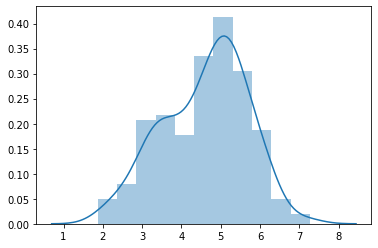

In [34]:
sns.distplot(y_pred[:,1]*10)
print(y_pred[:,1].mean()*10)
print(np.percentile(y_pred[:,1]*10,55))
print(np.percentile(y_pred[:,1]*10,25))